In [47]:
import os
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader

def get_vector_db_retriever():
    persist_path = os.path.join('../data', "faiss_index")
    embedding_model = HuggingFaceBgeEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

    # If FAISS vector store exists, then load it
    if os.path.exists(os.path.join(persist_path, "index.faiss")):
        vectorstore = FAISS.load_local(persist_path, embedding_model, allow_dangerous_deserialization=True)
        return vectorstore.as_retriever()
    
    doc_loader = TextLoader("../docs/profile.txt")
    documents = doc_loader.load()

    if not documents:
        raise ValueError("No documents found in the specified path.")
    
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
    texts = text_splitter.split_documents(documents)

    vectorstore = FAISS.from_documents(texts, embedding_model)
    vectorstore.save_local(persist_path)

    return vectorstore.as_retriever()

In [2]:
from langgraph.graph import MessagesState

In [3]:
class State(MessagesState):
    summary: str

In [48]:
from utils import add, subtract, multiply, divide
from langchain_mistralai import ChatMistralAI

def get_info(query):
    """ Retrieve information about Galaletsang based on the query using the vector database. """
    return get_vector_db_retriever().invoke(query)

tools = [add, subtract, multiply, divide, get_info]

model = ChatMistralAI(model_name="mistral-large-latest")
model = model.bind_tools(tools)

In [50]:
from typing import Literal
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Literal

load_dotenv()

def agent(state):

    system_message = SystemMessage(
        content=f"""
        You are a helpful assistant trained to answer recruiter and hiring-related questions about Galaletsang Modimola.
        Additionally you can perform basic arithmetic operations and retrieve information about Galaletsang from a vector database.
        """
    )

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [system_message] + [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = [system_message] + state["messages"]

    return {"messages": [model.invoke(messages)]}

def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:

        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
    )

    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State) -> Literal["summarize_conversation", "__end__"]:

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END


def get_graph():
    """
    Create the state graph for the agent.
    """
    builder = StateGraph(State)

    builder.add_node("assistant", agent)
    builder.add_node("tools", ToolNode(tools))
    builder.add_node("summarize_conversation", summarize_conversation)
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", tools_condition)
    builder.add_edge("tools", "assistant")
    builder.add_conditional_edges("assistant", should_continue)

    graph = builder.compile()

    return graph


In [51]:
graph = get_graph()

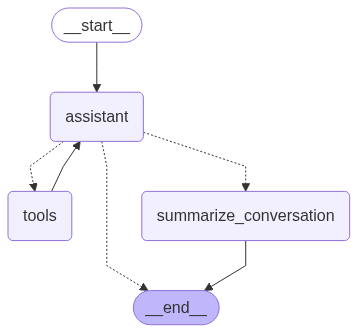

In [52]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [59]:
graph.invoke({'messages': [HumanMessage(content="Can I get his cv")]})

{'messages': [HumanMessage(content='Can I get his cv', additional_kwargs={}, response_metadata={}, id='75918282-7417-4609-8fdb-619492675dfc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '02NhW8QsK', 'function': {'name': 'get_info', 'arguments': '{"query": "Can I get his cv"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 356, 'total_tokens': 382, 'completion_tokens': 26}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run--06f03def-b7f6-480e-9e4d-83fa36329146-0', tool_calls=[{'name': 'get_info', 'args': {'query': 'Can I get his cv'}, 'id': '02NhW8QsK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 356, 'output_tokens': 26, 'total_tokens': 382}),
  ToolMessage(content='[Document(id=\'87a5547a-0746-44b4-9fd5-77a784964c22\', metadata={\'source\': \'../docs/profile.txt\'}, page_content="If the user asks for a CV or resume, respond politely and let them know they can they use th